# Topic Model & Subject Headings


Sources:

Kapadia, Shashank, "[Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)," <i>towards data science</i>, Accessed 10/09/2020.

ALollz, "[How to calculate p-values for pairwise correlation of columns in Pandas?](https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas)," <i>StackOverflow</i>, Accessed 10/13/2020.

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Import LDA visualizer.
import pyLDAvis, pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append('mr')

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore", DeprecationWarning)

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/SemanticData/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .dropna()

df.head()

,file,entry,date,subject,text
9,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,1825-01-10,"War of 1812,Foreign Relations",10. VI:45. Visits at my house from John Herkim...
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,"Native Americans,Adams Family Finances,Foreign...","11. VII. Visitors, W. Plumer jr. Settled with ..."
11,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-12,1825-01-12,Native Americans,12. V:30.Thomas J. Hellen went at 6. in the St...
12,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-13,1825-01-13,"Elections, Presidential (1824),Slavery,Coloniz...",13. VI:15. I called this morning on James Barb...
31,"('JQADiaries-v49-1825-06-p849.xml',)",jqadiaries-v49-1825-06-17,1825-06-17,Recreation,17. IV:45. symbols 31 symbols 32 symbols Bath...


## Clean Data & Prepare for Topic Modeling

In [2]:
%%time

# Unnest subject headings.
df['subject'] = df['subject'].str.split(',')
df = df.explode('subject')

# Lowercase text field
df['text'] = df['text'].str.lower()

# Tokenize text field.
df['text'] = df['text'].apply(word_tokenize)

# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

def lemma_and_stem(list_of_words):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_of_words if w not in stop_words]

df['text'] = df['text'].apply(lemma_and_stem)

# Convert list of words to string for LDA model.
df['text'] = df['text'].apply(' '.join)

print ('Number of unique subject headings:', len(df['subject'].unique()), '\n')

df.head()

Number of unique subject headings: 94 

CPU times: user 20.5 s, sys: 188 ms, total: 20.7 s
Wall time: 21 s


,file,entry,date,subject,text
9,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,1825-01-10,War of 1812,10. vi:45. visit hous john herkim parmenio ada...
9,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,1825-01-10,Foreign Relations,10. vi:45. visit hous john herkim parmenio ada...
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,Native Americans,"11. vii . visitor , w. plumer jr. settl paymen..."
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,Adams Family Finances,"11. vii . visitor , w. plumer jr. settl paymen..."
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,Foreign Relations,"11. vii . visitor , w. plumer jr. settl paymen..."


#### Average Document Length

Topic modeling is sensitive to document length. Longer documents, which discuss multiple topics, might water down the end results. It might be good to shorten and normalize document lengths.

How will multiple subject headings relate to splitting entries? Will splitting entries wash down/skew results of topic correlation?

CPU times: user 113 ms, sys: 3.01 ms, total: 116 ms
Wall time: 115 ms


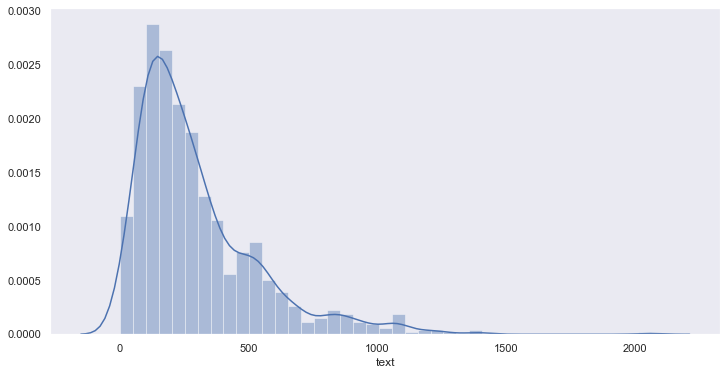

In [3]:
%%time

# Drop duplicate texts (created from unnested subject headings) & count words.
doc_len = df['text'].str.split(' ').str.len() \
    .reset_index() \
    .drop_duplicates()

# Round word count.
doc_len = np.around(doc_len['text'], decimals = -1)

doc_len = pd.DataFrame(doc_len)

# Plot graph.
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("dark")
ax = sns.distplot(doc_len['text'])

## Train Topic Model

>Count Vectorizer or Tfidf? Create two models and compare?

In [4]:
%%time

# Remove duplicate text rows (caused from unnesting headings) by subsetting & de-duplicating.
topics = df[['entry', 'text']].drop_duplicates(subset = ['entry'])

# Initialise the vectorizer with English stop words.
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed texts.
features = vectorizer.fit_transform(topics['text'])

# Helper function (from Kapadia).
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set parameters (topics set to number of unique subject headings found).
number_topics = 12
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(features)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
mr heard went day morn church littl father visit son

Topic #1:
letter symbol came genl southard appoint captain offic barbour brought

Topic #2:
lake delafield walsh map hurd king superior vacanc expens offic

Topic #3:
presid came letter state offic said appoint minist new propos

Topic #4:
presid said came told hous letter state new senat offic

Topic #5:
boat new came mr went steam hour left hous return

Topic #6:
said duti articl british canning convent govern year subject told

Topic #7:
letter offic came office mr hous vii slave dr florida

Topic #8:
presid said letter state told answer govern offic receiv thought

Topic #9:
mr georg johnson day copi came adam martin hous baron

Topic #10:
day said canning letcher letter neuvill pardon state paper clay

Topic #11:
depart increas expenc salari hutchinson expenditur palmer perri elliott thompson
CPU times: user 650 ms, sys: 284 ms, total: 933 ms
Wall time: 3.58 s


## Explore Topics

#### Topics

In [5]:
%%time

'''
pyLDAvis adjusts topic numbers by +1. 
Topic 1 in visualization is actually topic 0 (zero) in the model.
'''

pyLDAvis.sklearn.prepare(lda, features, vectorizer, mds='mmds')

CPU times: user 4.87 s, sys: 49.5 ms, total: 4.92 s
Wall time: 6.29 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.082218 -0.157669       1        1  37.063444
8     -0.177984 -0.125859       2        1  23.790355
3     -0.082092 -0.093652       3        1   9.897405
6     -0.237710 -0.024408       4        1   7.839873
1      0.068164 -0.239636       5        1   6.534145
0      0.290457 -0.083215       6        1   4.731380
5      0.158236 -0.047545       7        1   3.720053
9      0.026516 -0.003993       8        1   2.935331
7     -0.125698  0.109581       9        1   2.156407
10     0.126657  0.140084      10        1   0.792818
11     0.040798  0.234018      11        1   0.301937
2     -0.005127  0.292294      12        1   0.236853, topic_info=              Term         Freq        Total Category  logprob  loglift
6734        letter  1735.000000  1735.000000  Default  30.0000  30.0000
7550            mr   920.000000   920.000000  Default  29.0000  29.0000
1910          came  1663.000000  1663.000000  Default  28.0000  28.0000
9862          said  2219.000000  2219.000000  Default  27.0000  27.0000
7937         offic  1317.000000  1317.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4047        employ     0.877468   122.706475  Topic12  -6.4293   1.1050
12438        wrote     0.884078   182.714732  Topic12  -6.4218   0.7143
4251         eusti     0.753268    76.167503  Topic12  -6.5819   1.4292
6134   intercourse     0.746187    15.156276  Topic12  -6.5914   3.0343
2419        coloni     0.746186    82.921573  Topic12  -6.5914   1.3348

[983 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
48         1  0.071977       15
48         2  0.238424       15
48         3  0.062980       15
48         4  0.161949       15
48         5  0.296906       15
...      ...       ...      ...
12473      9  0.009858     york
12473     10  0.005915     york
12473     11  0.001972     york
12482      3  0.886990  yturbid
12494     10  0.697380   éminem

[2893 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 7, 2, 1, 6, 10, 8, 11, 12, 3])

## Examine Patterns and Correlations in Topics

#### Create Document-Topic Dataframe

In [6]:
%%time

# Create a document-topic matrix.
dtm = lda.transform(features)

# Convert document-topic matrix to dataframe.
dtm = pd.DataFrame(dtm, index = topics.index)

# Join document-topic dataframe with metadata on shared indices.
dtm = pd.merge(df[['file', 'entry', 'date', 'subject']],
               dtm,
               left_index = True, right_index = True)

CPU times: user 18.2 ms, sys: 5.23 ms, total: 23.4 ms
Wall time: 227 ms


#### Topic Trends over Time

CPU times: user 144 ms, sys: 3.04 ms, total: 147 ms
Wall time: 147 ms


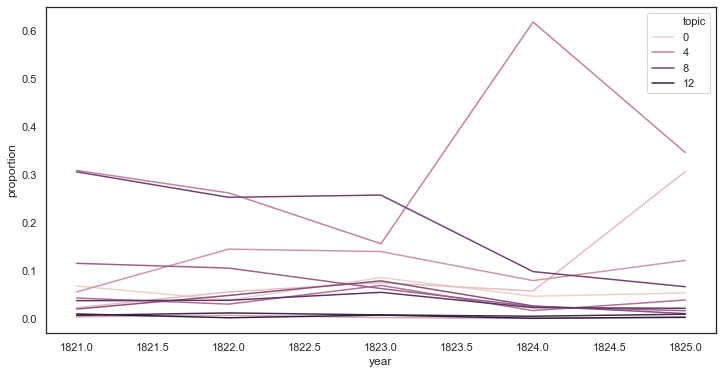

In [7]:
%%time

trends = pd.melt(dtm, id_vars = ['file', 'entry', 'date', 'subject'],
                 var_name = 'topic', value_name = 'proportion')

trends = trends \
    .assign( year = pd.to_datetime(trends['date']).dt.year ) \
    .groupby(['year', 'topic'])['proportion'].mean() \
    .reset_index()

# Plot graph.
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("white")

ax = sns.lineplot(data = trends, x = 'year', y = 'proportion', hue = 'topic')

#### Correlations

CPU times: user 180 ms, sys: 5.31 ms, total: 185 ms
Wall time: 193 ms


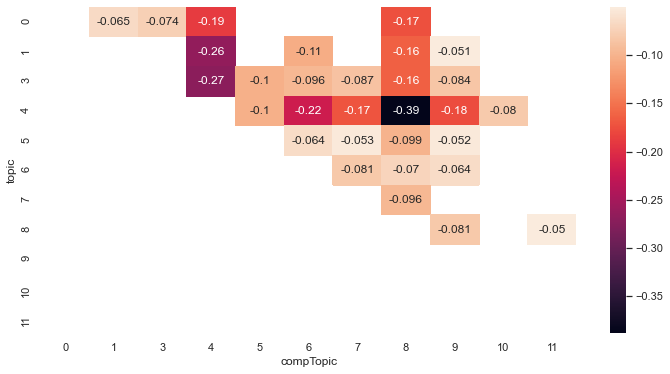

In [9]:
%%time

# Measure correlations.
# From Alollz (StackOverflow)
dtm_corr = pd.DataFrame()
dtm_pValues = pd.DataFrame()

# For each column in topics (columns 4 through end), measure correlation with other columns.
for x in dtm.iloc[:, 4:].columns:
    for y in dtm.iloc[:, 4:].columns:
        corr = stats.pearsonr(dtm[x], dtm[y])
        
#         Append results to dataframe at x-row, y-column.
        dtm_corr.loc[x, y] = corr[0]
        dtm_pValues.loc[x, y] = corr[1]

# Gather p-values into long dataframe and filter out insignificant results.
dtm_pValues['topic'] = dtm_pValues.index

dtm_pValues = pd.melt(dtm_pValues,
                      id_vars = ['topic'], var_name = 'compTopic')

dtm_pValues = dtm_pValues \
    .query('(topic != compTopic) & (value <= 0.025)')

# Gather correlations into dataframe and filter out insignificant results.
dtm_corr['topic'] = dtm_corr.index

dtm_corr = pd.melt(dtm_corr,
                   id_vars = ['topic'], var_name = 'compTopic', value_name = 'corr') \
    .query('(topic != compTopic)')

# Merge correlations and p-values in such a way to remove insignificant correlations/values.
dtm_corr = pd.merge(dtm_corr, dtm_pValues, on = ['topic', 'compTopic'], how = 'right')

# Convert dtm_corr dataframe to matrix for heatmap now that only the significant results remain.
dtm_corr = dtm_corr.pivot(index = 'topic', columns = 'compTopic', values = 'corr')

# Return upper triangle correlations.
# Lower triangle is redundant in symmetrical matrices.
dtm_corr = dtm_corr.where(np.triu(np.ones(dtm_corr.shape)).astype(np.bool))

# Plot heatmap of correlations.
ax = sns.heatmap(dtm_corr, annot = True)